# The "how to" for estimating the parameters of an arbitrary reaction-diffusion system

Reaction-diffusion systems are omnipresent in nature for any type of pattern creation. This short notebook intends to provide a simple but informative example for using the implemented parameter estimation method. We assume we know the form of the ODEs that describe the reaction-diffusion system but don't know the exact parameters that lead to the observed pattern. Thus, before starting you should have
1. A dataset describing the temporal evolution of your pattern for each involved species and
2. The form of the ODEs that are responsible to create such a pattern.

It's not necessarily important to know the exact mechanism, but you should know the spatial dimension of the diffusion (e.g. is it in a one or two-dimensional shape) and whether there is any non-linear breakdown involved. 

In this example (which is taken from the KTH class DD2435), we assume a system with two protein species $A$ and $B$. Their relationship is given by the following ODEs

\begin{equation}
\frac{da}{dt} = c_1 a + c_2 b - r_a a^3 + D_a \nabla^2 a;
\end{equation}
\begin{equation}
\frac{db}{dt} = c_3 a + c_4 b - r_b b^3 + D_b \nabla^2 b;
\end{equation}

where $a$ and $b$ denote the deviation of the equilibrium concentration of $A$ and $B$, respectively. $c_1$, $c_2$, $c_3$, and $c_4$ are the interaction parameters. $r_a$ and $r_b$ represent the non-linear breakdown of species $A$ and $B$. Lastly  $D_a$ and $D_b$ are the diffusion coefficient. Note that the layout of the equations is broad and does not require any particular knowledge of the actual interaction. Even the form of $\nabla$ is dependent on the available data. The only real design choice is taken by the non-linear breakdown.

*Tip*: if you're unsure about the non-linear breakdown, evaluate the prediction after parameter search over several choices for the breakdown term. 

In the following, we use dummy data from 300 time points and 50 positions along a one-dimensional array.

## Prepare your code

First, we need to load the necessary libraries. The library uses `numpy`. For using the parameter estimation method, load additionally the `fit` method of `fitting` module as well as the `ODEGeneral` class. To make our life easier, we load the pre-defined one-dimensional $\nabla^2$ method. But even that can be customised by you to match you own requirements for the spatial behaviour. Moreover, we use `matplotlib` for plotting the results, but any visualisation library of you choice would do. We set the verbosity value to 0, because we don't want to have lengthy outputs in this notebook. But feel free to increase this parameter for your own implementations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ODE import ODEGeneral, nabla_sq_1d
from fitting import fit

VERBOSITY = 0

The `ODEGeneral` class requires the definition of three functions. One of them defines the spatial diffusion. In order to keep it simple, we use the pre-defined one-dimensional `nabla_sq_1d` method. 

In [2]:
def calc_diffusion(substance, h=1, axis=1):
    return nabla_sq_1d(substance, h=1, axis=1)

Secondly, we need to implement a concatenation method that transforms all input data values of the ODE into the necessary form. The input values of the first ODE are $a$, $b$, $a^3$ and $\nabla^2 a$. We make use of some internal definitions of the `ODEGeneral` class, which is why we pass `self` as a parameter. Every `ODEGeneral` instance possesses a unique index that defines its position in the data. Don't worry about it for now, we're going to come back to it below. You should know, though, that the input `diffs` has the dimensions `(species, time, space)`. `diffs[self.own_idx]` returns the data that correspond to the species whose behaviour is described by this ODE instance. Additionally, we use the instance's `func_nabla` function, which we define when creating the instance. You guess right, this is going to be the `nabla_sq_1d` function. 

*Note*: Alternatively, you could use `nabla_sq_1d` right away and pass `None` during the initialisation of the ODE. However, to keep the example rather general, I personally prefer making use of `self.func_nabla`.

In a last step, we stack all input parameters together and apply all non-linear transformations that might be necessary. In a nutshell: the output of the function should be an array that only needs to be multiplied by the corresponding parameters. 

**About dimensionality**: Keep in mind that your data is multi-dimensional in time and space. The required output of this function has the dimensions `(parameter, time, space)`. Thus, for our example the output shape is `(4, 300, 50)`. The transpositions in the last line help make this code a one-liner.

In [3]:
def conc_params(self, diffs):
    own_spec = diffs[self.own_idx]
    spatial_diff = self.func_nabla(own_spec)
    return np.dstack((diffs.T, np.power(own_spec, 3).T, spatial_diff.T)).T

Lastly, we need to define how the ODE parameters and the the input (that has been transformed by the `conc_params` method) result in the temporal change, for example $\frac{da}{dt}$. Note that the input is composed of `diffs`---which are the input values from `conc_params`---and `coeff`---which are the current estimations of the coefficients. As explained above, the dimensions of `diffs` are `(parameter, time, space)`. During parameter estimation, there is one set of parameters per spatial position. Therefore, the dimension is `(space, parameter)` or in our example `(50, 4)`. The parameter order in `coeff` follows the `diffs`. 

We first extract the input values which are $a$ and $b$ (in the variable `conc`), $a^3$ (`own_spec`), and the diffusion (`nabla`). You canv verify that the indices correspond to the positions in the return array of the `conc_params` method. I use a little trick (`np.einsum`) and to speed-up the calculations (in my experience), but feel free to implement it your own way (see for example comments).

In [4]:
def calc_reaction(diffs, coeff):
#     conc = diffs[:2]
#     own_spec = diffs[2]
#     nabla = diffs[3]
#     infl_conc = np.einsum('ki,ijk->jk', coeff[:, :2], conc)
#     infl_own_spec = coeff[:, 2] * own_spec
#     infl_nabla = coeff[:, 3] * nabla
#     return infl_conc + infl_nabla + infl_own_spec
    return np.einsum('ki,ijk->jk', coeff, diffs)

## Fit your ODEs

After the setup, we're ready to go find the parameters for our ODE. First, we load the data. An example is given in the files `data/A-rand.csv` and `data/B-rand.csv`. `t` is the corresponding time points at which the data was sampled. The original parameters that created the data were:
- $c_1$ = 1, $c_2$ = -1, $r_a$ = -0.1, and $D_a$ = 1
- $c_3$ = 1, $c_4$ = -1, $r_b$ = -0.1, and $D_b$ = 3

In other words: $A$ is an autocatalytic activator and $B$ an inhibitor.

In [5]:
# Original parameters A
# 1, -1, -0.1, 1
A = np.genfromtxt('data/A-rand.csv', delimiter=',')
# Original parameters B
# 1, -1, -0.1, 3
B = np.genfromtxt('data/B-rand.csv', delimiter=',')
t = np.genfromtxt('data/Time.csv', delimiter=',')

Now it's time to define the ODEs. We pass an initial guess for the parameter values (per position) as well as the three functions that we defined above. 

Now we come back to the `own_idx` ID that we talked about before. With every ODE instance, this parameter is increased. Thus, every ODE instance has an index value at which it expects the corresponding data. We reset the index counter for the ODE classes. This wouldn't be necessary if we ran this example only once. It's also not necessary if you have only one system of ODEs to process. However, if you have different systems for which you want to find the corresponding parameters, it's crucial to reset this index each time after the whole set of ODEs is defined. You can call it on any instance, and it will reset index for the entire class.

In [6]:
ode_A = ODEGeneral(
    np.tile(np.random.random(4), 50).reshape(50, 4),
    calc_reaction,
    calc_diffusion,
    conc_params
)
ode_B = ODEGeneral(
    np.tile(np.random.random(4), 50).reshape(50, 4),
    calc_reaction,
    calc_diffusion,
    conc_params
)

ode_A.reset_idx()

Now we run the actual estimation method. The first paramter is the data in an array. Note that the order corresponds to the order in which the ODEs were created. The second parameter is the list of ODEs (again in the same order). We pass the time points at which the data was sampled, `w_model` is a weighting parameter which is unimportant for this example, `degree` sets the degree of the splines that are used for estimating the parameters, `delta` is the accuracy threshold, `success_ratio` defines for how many positions `delta` must be met, and `verbosity` sets the amount of output that is produced by this function.

As remarked in the comment, the degree can have a substantial impact (see github readme). I recommend to use at least `degree=4`, which should do fine for most applications. Yet it might be necessary to lower the value if the quality of your data is poor or you have only some few time points.

In [7]:
ode_A, ode_B = fit(
    np.asarray([A[:-1], B[:-1]]),
    [ode_A, ode_B],
    x=t,
    w_model=1.,
    degree=5,  # sensitive to the degree. Using degree of 4 or 5 works perfect
    delta=1e-12,
    success_ratio=1.,
    verbosity=VERBOSITY
)

/home/leo/phd/tc-modelling/fitting.py:35: RuntimeWarning: invalid value encountered in true_divide
  d = np.asarray([k * (B(x, k-1, i, t) / (t[i + k] - t[i]) - B(x, k-1, i+1, t) / (t[i+k+1] - t[i+1])) for i in range(n)])


## Results

The `fit` method returns the ODEs with the estimated parameters. As mentioned above, there will be one parameter per position in space. In most cases you're interested in the average behaviour, as the system of ODEs is assumed to be independent in space. Nevertheless, we can run already our simulations with having one ODE per position. We use 3000 time steps with each representing $\Delta t = 0.1$. This results in the following outcome. Top row is the original data, bottom row is the approximation of species $A$ (left) and $B$ (right). As you can see, the outcome doesn't really represent what we'd expect. I recommend to use the mean value over all parameters to be more robust. This is explained below. 

In [8]:
a = A[0, :].reshape(1, A.shape[1]).copy()
b = B[0, :].reshape(1, B.shape[1]).copy()

a_history = [a[0]]
b_history = [b[0]]
for _ in np.arange(3000):
    a_dev = ode_A.calc(np.asarray([a, b]), dt=0.1)
    b_dev = ode_B.calc(np.asarray([a, b]), dt=0.1)
    a += a_dev
    b += b_dev
    a_history.append(np.copy(a[0]))
    b_history.append(np.copy(b[0]))

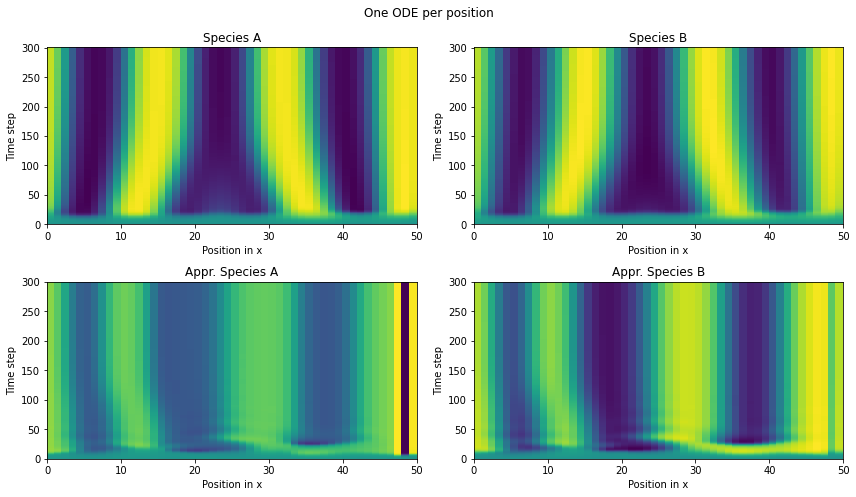

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))
ax[0, 0].pcolor(np.asarray(A), vmin=A.min(), vmax=A.max())
ax[0, 0].set_title('Species A')
ax[0, 0].set_xlabel('Position in x')
ax[0, 0].set_ylabel('Time step')
ax[0, 1].pcolor(np.asarray(B), vmin=B.min(), vmax=B.max())
ax[0, 1].set_title('Species B')
ax[0, 1].set_xlabel('Position in x')
ax[0, 1].set_ylabel('Time step')
amin, amax = np.min(a_history), np.max(a_history)
bmin, bmax = np.min(b_history), np.max(b_history)

ax[1, 0].set_title('Appr. Species A')
ax[1, 0].set_xlabel('Position in x')
ax[1, 0].set_ylabel('Time step')
ax[1, 0].pcolor(np.asarray(a_history), vmin=amin, vmax=amax)
ax[1, 1].set_title('Appr. Species B')
ax[1, 1].set_xlabel('Position in x')
ax[1, 1].set_ylabel('Time step')
ax[1, 1].pcolor(np.asarray(b_history), vmin=bmin, vmax=bmax)

ax[1, 0].set_yticks(np.arange(0, 3001, 500))
ax[1, 1].set_yticks(np.arange(0, 3001, 500))
ax[1, 0].set_yticklabels(np.arange(0, 301, 50))
ax[1, 1].set_yticklabels(np.arange(0, 301, 50))

fig.suptitle('One ODE per position')
fig.tight_layout()
plt.show()

As mentioned above, we actually want to have only one ODE for all positions rather than one each. We simply take the mean over all positions and repeat the simulation. Note that most parameter values for $A$ and $B$ are lower than expected, whilst $r_a$ and $r_b$ are close to the original value. Due to the non-linear breakdown to the power of 3, this parameter has large weight on the parameter estimation. You should keep that in mind when designing your formulas. Nevertheless, it should be stressed that the remaining values have the expected ratios. For example $D_b$ is thee times as big as $c_3$; $c_1 = -c_2 = D_a$; and roughly $c_1 = c_3$ as well as $c_2 = c_4$. This results in the expected pattern after a small offset. Hence the take home message: The smaller the non-linear term, the smaller the effect of any bias.

In [10]:
ode_A.coeff.shape

(50, 4)

In [11]:
print('A coefficients have a median of c1=%.2f, c2=%.2f, ra=%.2f, and Da=%.2f ' 
      '\nwith a variance of c1=%.2f, c2=%.2f, ra=%.2f, Da=%.2f' %
      (*np.mean(ode_A.coeff, axis=0), *ode_A.coeff.var(axis=0)))

print('\nB coefficients have a median of c3=%.2f, c4=%.2f, rb=%.2f, and Db=%.2f ' 
      '\nwith a variance of c3=%.2f, c4=%.2f, rb=%.2f, and Db=%.2f' %
      (*np.mean(ode_B.coeff, axis=0), *ode_B.coeff.var(axis=0)))

A coefficients have a median of c1=0.73, c2=-0.71, ra=-0.08, and Da=0.73 
with a variance of c1=0.10, c2=0.14, ra=0.00, Da=0.12

B coefficients have a median of c3=0.54, c4=-0.51, rb=-0.08, and Db=1.66 
with a variance of c3=0.10, c4=0.15, rb=0.00, and Db=0.77


In [12]:
a_param = np.mean(ode_A.coeff, axis=0)
b_param = np.mean(ode_B.coeff, axis=0)
ode_A.coeff = np.tile(a_param, ode_A.coeff.shape[0]).reshape(ode_A.coeff.shape)
ode_B.coeff = np.tile(b_param, ode_B.coeff.shape[0]).reshape(ode_B.coeff.shape)

In [13]:
a = A[0, :].reshape(1, A.shape[1]).copy()
b = B[0, :].reshape(1, B.shape[1]).copy()

a_history = [a[0]]
b_history = [b[0]]
for _ in np.arange(3000):
    a_dev = ode_A.calc(np.asarray([a, b]), dt=0.1)
    b_dev = ode_B.calc(np.asarray([a, b]), dt=0.1)
    a += a_dev
    b += b_dev
    a_history.append(np.copy(a[0]))
    b_history.append(np.copy(b[0]))

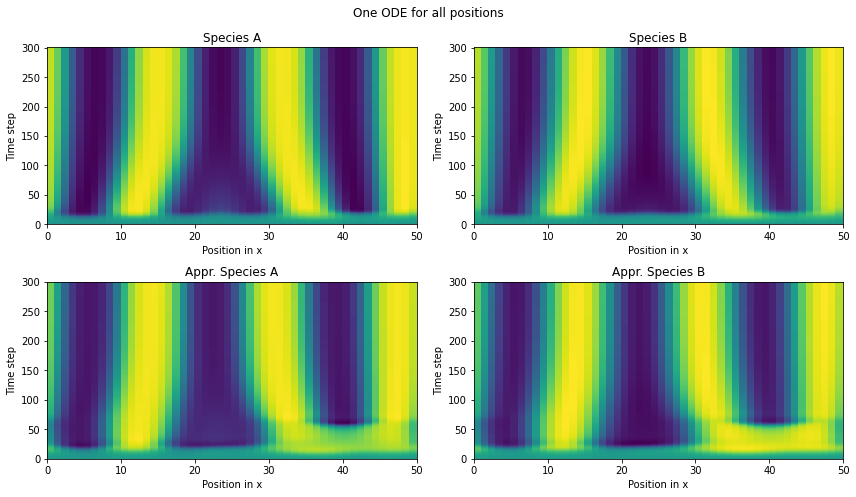

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))
ax[0, 0].pcolor(np.asarray(A), vmin=A.min(), vmax=A.max())
ax[0, 0].set_title('Species A')
ax[0, 0].set_xlabel('Position in x')
ax[0, 0].set_ylabel('Time step')
ax[0, 1].pcolor(np.asarray(B), vmin=B.min(), vmax=B.max())
ax[0, 1].set_title('Species B')
ax[0, 1].set_xlabel('Position in x')
ax[0, 1].set_ylabel('Time step')
amin, amax = np.min(a_history), np.max(a_history)
bmin, bmax = np.min(b_history), np.max(b_history)

ax[1, 0].set_title('Appr. Species A')
ax[1, 0].set_xlabel('Position in x')
ax[1, 0].set_ylabel('Time step')
ax[1, 0].pcolor(np.asarray(a_history), vmin=amin, vmax=amax)
ax[1, 1].set_title('Appr. Species B')
ax[1, 1].set_xlabel('Position in x')
ax[1, 1].set_ylabel('Time step')
ax[1, 1].pcolor(np.asarray(b_history), vmin=bmin, vmax=bmax)

ax[1, 0].set_yticks(np.arange(0, 3001, 500))
ax[1, 1].set_yticks(np.arange(0, 3001, 500))
ax[1, 0].set_yticklabels(np.arange(0, 301, 50))
ax[1, 1].set_yticklabels(np.arange(0, 301, 50))

fig.suptitle('One ODE for all positions')
fig.tight_layout()
plt.show()